# An introduction to Deep Generative Models:
## Variational Autoencoder in Pytorch
**Sources:**
- Adaptation from [VAE notebook](https://github.com/Jackson-Kang/Pytorch-VAE-tutorial/tree/master)
- [Variational AutoEncoder](https://arxiv.org/pdf/1312.6114.pdf) (VAE, D.P. Kingma et. al., 2013)

In [1]:
import os
import json
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [2]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(8, 8))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

def show_first_batch(loader):
    for batch in loader:
        show_images(batch[0], "Images in the first batch")
        break

In [3]:
# Model Hyperparameters

dataset_path = './datasets'

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
DEVICE = 'mps'

batch_size = 100

x_dim  = 784
hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 500

### Load (or download) Dataset

In [4]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=False)
val_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
val_loader  = DataLoader(dataset=val_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Define our model: Variational AutoEncoder (VAE)


A Variational AutoEncoder can be splitted into three different components:

- **Encoder**: The encoder maps the input $\mathbf{x}$ of dimension D onto a latent space $\mathbf{z}$ of dimension d (d << D). In case of a VAE, the output of the encoder is the mean $\mu_{z,\theta}(\mathbf{x})$ and variance $\Sigma_{z,\theta}(\mathbf{x})$ (usually isotropic).

- **Decoder**: The decoder maps the latent coordinates $\mathbf{z}$ back to the origial input $\mathbf{x}$. The output of the decoer can be just the mean $\mu_{x,\phi}(\mathbf{z})$, or mean and variance $\Sigma_{x,\phi}(\mathbf{z})$.

- **VAE model**: Maps the inputs to a latent space, uses the reparametrization trick to sample a latent coordinate, and decodes the latent coordinate back to the input space using the decoder.

In [5]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [6]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [7]:
class VAE(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(VAE, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var
        
    def decode(self, z):
        return self.Decoder(z)

In [8]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = VAE(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Define Loss function (reprod. loss) and optimizer

Evidence Lower Bound (ELBO) = reconstruction loss - KL divergence

$\mathcal{L}(\theta, \phi, \mathbf{x}) := \text{log } p_{\theta}(\mathbf{x}) - KL(q_{\phi}(\mathbf{z}) || p_{\theta}(\mathbf{z}|\mathbf{x}))$ 

In [9]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reconstruction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reconstruction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Train Variational AutoEncoder (VAE)

In [10]:
train=False
save_every = 2
checkpoint_path = './logs/vae/checkpoints'

loss_hist = {'epoch': [], 'train_loss': [], 'val_loss': []}

print("Start training VAE...")
step = 0

if train:
    for epoch in range(epochs):
    
        #Training
        model.train()
        train_loss = 0.0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.view(batch_size, x_dim)
            x = x.to(DEVICE)
    
            optimizer.zero_grad()
    
            x_hat, mean, log_var = model(x)
            loss = loss_function(x, x_hat, mean, log_var)
            
            train_loss += loss.item()
            
            loss.backward()
            optimizer.step()
    
        train_loss = train_loss/len(train_loader.dataset)
        loss_hist['train_loss'].append(train_loss)
    
        #Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_idx, (x, _) in enumerate(val_loader):
                x = x.view(batch_size, x_dim)
                x = x.to(DEVICE)    
                x_hat, mean, log_var = model(x)
                loss = loss_function(x, x_hat, mean, log_var)
                
                val_loss += loss.item()
    
            val_loss = val_loss/len(val_loader.dataset)
            loss_hist['val_loss'].append(val_loss)
    
        loss_hist['epoch'].append(epoch)
    
        print(f'Epoch: {epoch} - Train loss: {train_loss} - Val loss: {val_loss}')
    
        if epoch % save_every == 0 or epoch == epochs-1:
            print('Saving model...') 
            path = os.path.join(checkpoint_path, f'vae_mnist_epoch_{epoch}.ckpt')
            torch.save(model.state_dict(), path)
            with open('./logs/vae/loss.json', 'w') as out_file:
                json.dump(loss_hist, out_file, indent = 6)
                
    print("Finish!!")

else:
    ckpt_path = os.path.join(checkpoint_path, 'vae_mnist_epoch_372.ckpt')
    model.load_state_dict(torch.load(ckpt_path))
    model.eval()    

Start training VAE...


Text(0.5, 1.0, 'VAE loss')

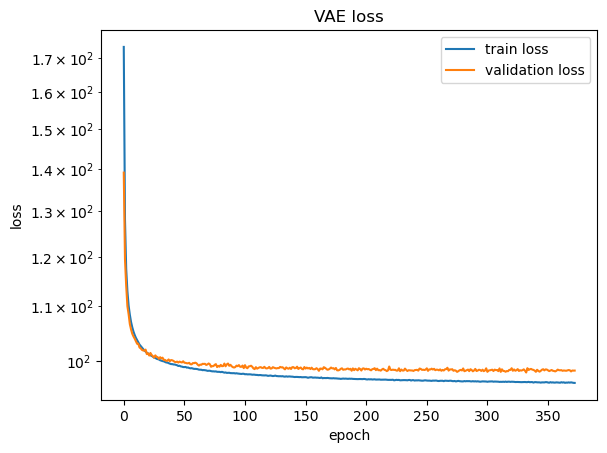

In [11]:
import matplotlib.pyplot as plt
with open('./logs/vae/loss.json', 'r') as in_file:
    loss_hist = json.load(in_file)

plt.semilogy(loss_hist['epoch'], loss_hist['train_loss'])
plt.semilogy(loss_hist['epoch'], loss_hist['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train loss','validation loss'])
plt.title('VAE loss')

### Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [12]:
# Generate samples
num_samples=16
H = 28
W = 28
def gen_samples(num_samples):
    model.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, latent_dim).to(DEVICE)
        generated_images = model.decode(noise)
    return generated_images.reshape(num_samples, H, W)

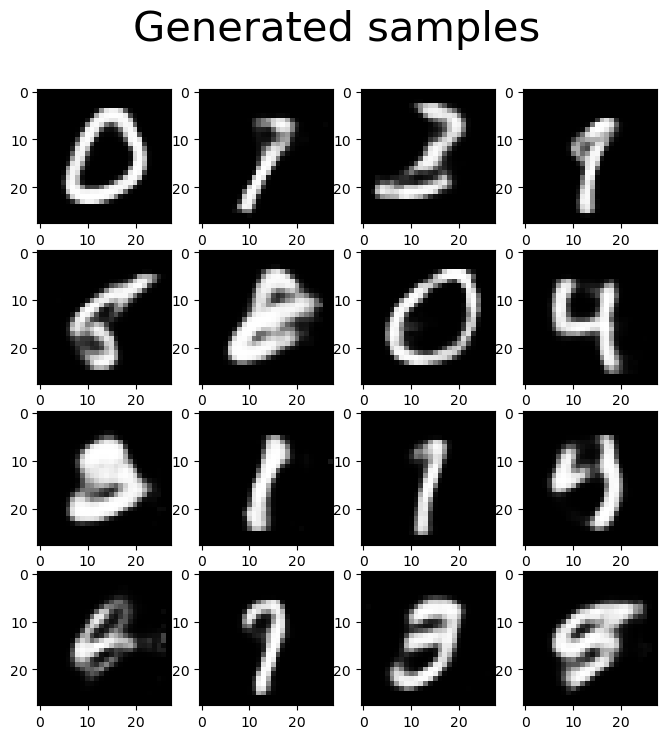

In [13]:
generated = gen_samples(num_samples)
show_images(generated, "Generated samples")